In [2]:
import os
import sqlite3
import time

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
#plt.rcParams['legend.handlelength'] = 0
from matplotlib.ticker import MultipleLocator, FuncFormatter
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import seaborn as sns
sns.set_palette(sns.color_palette("cubehelix", 8))

In [3]:
def get_dataframes(query, databases):
    dataframes = []
    for database in databases:
        db = sqlite3.connect(database)
        dataframes += [pd.read_sql_query(query, db)]
        db.close()
    return pd.concat(dataframes)

In [4]:
query = 'select start_submit, end_submit, returned, tasks, connected_managers, cores_per_manager, sleep_seconds from analyses'
analyses = get_dataframes(query, ['data.db'])
analyses['makespan'] = (analyses.returned - analyses.start_submit) / 60.
analyses['cores'] = analyses.connected_managers * analyses.cores_per_manager
analyses['date'] = [time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t)) for t in analyses.returned]
analyses['submit_minutes'] = (analyses.end_submit - analyses.start_submit) / 60.

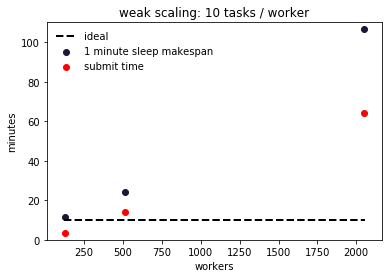

In [5]:
plt.scatter(analyses.cores, analyses.makespan, label='1 minute sleep makespan')
plt.ylabel('minutes')
plt.ylim(ymin=0, ymax=110)

plt.scatter(analyses.cores, analyses.submit_minutes, label='submit time', color='red')
plt.ylim(ymin=0)
ideal_time = analyses.tasks[0] / analyses.cores[0] * analyses.sleep_seconds[0] / 60
plt.axhline(y=ideal_time, xmin=0.05, xmax=0.95, linewidth=2, linestyle='dashed', color='black', label='ideal')

plt.xlabel('workers')
plt.title('weak scaling: 10 tasks / worker')

plt.legend(loc='upper left', frameon=False)
plt.savefig('plots/weak_scaling.pdf', bbox_inches="tight")